# Clase 9 (Detección de Humor con Word Embeddings)

En esta clase utilizaremos un conjunto de vectores de palabras pre-entrenados y modelos de redes neuronales para detectar humor en textos cortos. A lo largo de este *notebook* definiremos, entrenaremos y evaluaremos modelos neuronales con un conjunto de datos impartido y vectores pre-entrenados.

## Cargar Word Embeddings Y Corpus

Primero cargaremos el repertorio de vectores y el conjunto de datos. 

Ejecute el siguiente bloque de código para importar un conjunto de paquetes que serán de utilidad.

In [1]:
%pylab inline
import IPython
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### Word Embeddings

El repertorio de vectores de palabras se encuentra en el archivo **aaa_humor_vectores.txt**, vamos a descargarlo y cargarlo en memoria en una estructura que sea conveniente.

Descargue el archivo de: https://www.fing.edu.uy/~mathiase/cpap/aaa_humor_vectores.txt

**Nota:**
Este archivo de vectores fue generado utilizando el modelo para el español disponible en: <br>
https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz


** Ejecute el siguiente bloque para cargar el conjunto de vectores. **

In [2]:

def load_vectors(filename):
  f = open(filename, 'r')
  wd2ind, X, ind = dict(), list(), -1
  for l in f:
    l_split = l.split()
    word, vector = l_split[0], list(map(float, l_split[1:]))
    wd2ind[word] = ind = ind + 1      
    X.append(vector)
  f.close()
  X.append([0]*len(X[0]))  # vector for <UNK> words 
  X =  np.array(X)  # convert to numpy.array
  wd2vect = lambda x: X[wd2ind.get(x, -1)]
  wd2vect.name, wd2vect.dim, wd2vect.X = filename, len(X[0]), X
  wd2vect.ind = wd2ind 
  return wd2vect

vectores = load_vectors('./aaa_humor_vectores.txt')


Ejecute el siguiente bloque para desplegar la cantidad de vectores cargados.

In [3]:
len(vectores.ind)

35566

Ejecute el siguiente bloque para desplegar la dimensión de los vectores cargados.

In [4]:
vectores.dim

300

Ejecute el siguiente bloque para obtener el vector de la palabra lenguaje.

In [5]:
vectores('lenguaje')

[-0.04734,
 -0.0024742,
 0.018312,
 0.0048214,
 -0.021698,
 7.4022e-06,
 0.053025,
 -0.0048587,
 -0.023624,
 0.011403,
 0.06944,
 -0.0015276,
 -0.082462,
 -0.06249,
 -0.062907,
 0.062955,
 -0.013196,
 -0.033238,
 0.0093367,
 0.10612,
 -0.057377,
 0.025159,
 -0.0079073,
 0.035248,
 0.01892,
 0.010016,
 -0.0035982,
 0.019469,
 0.00087444,
 0.042121,
 0.03054,
 0.062031,
 0.063696,
 0.0094161,
 -0.030604,
 0.0017967,
 0.015747,
 -0.0055513,
 0.036179,
 0.012838,
 -0.012785,
 -0.05914,
 -0.012411,
 0.034747,
 -0.007707,
 0.015394,
 0.015947,
 -0.0075885,
 0.058565,
 0.013553,
 0.008315,
 -0.038522,
 -0.0073644,
 -0.039279,
 0.014003,
 0.010481,
 -0.015383,
 0.021368,
 -0.010022,
 -0.0091889,
 -0.0010203,
 0.012559,
 0.03262,
 -0.030173,
 0.015476,
 0.0082857,
 -0.013605,
 -0.0046215,
 -0.021249,
 -0.089114,
 -0.028212,
 0.0037297,
 -0.037939,
 0.00045507,
 -0.022071,
 0.016579,
 0.030966,
 -0.021418,
 -0.021257,
 -0.046978,
 -0.021838,
 -0.021539,
 -0.036602,
 0.059912,
 -0.038392,
 0.0421

### Corpus de Humor

El corpus de humor está fraccionado en tres conjuntos: entrenamiento (*train*), validación (*val*) y evaluación (*test*). Los conjuntos son impartidos en los archivos **data_train.csv**, **data_val.csv** y **data_test.csv**.

Primero cargaremos los archivos y los segmentaremos en palabras (*tokenize*).

** Complete la asignación que falta en el bloque siguiente para cargar el corpus de humor. **

In [6]:
import csv
import nltk
from nltk.tokenize import regexp_tokenize

# función para segmentar la entrada en palabras
tokenizer = lambda x: regexp_tokenize(x, pattern='[^\w\s]|\w+')

def load_corpus(csvfile):
    corpus = list()
    with open(csvfile) as f:
        freader = csv.reader(f, delimiter=',', quotechar='"')
        next(freader, None)  # para escapar los headers
        for row in freader:
            c_0 = tokenizer(row[0])
            c_1 = row[1]
            r = [c_0, c_1]
            corpus.append(r)
    return corpus
            
train = load_corpus('./data_train.csv')
val = load_corpus('./data_val.csv')
test = load_corpus('./data_test.csv')

print('# train:',len(train)) 
print('# val:',len(val)) 
print('# test:',len(test))

train[0]

# train: 16999
# val: 2000
# test: 5000


[['Niveles',
  'de',
  'retraso',
  'mental',
  ':',
  '—',
  'Bajo',
  '.',
  '—',
  'Medio',
  '.',
  '—',
  'Alto',
  '.',
  '—',
  'Elevado',
  '.',
  '—',
  'Regresar',
  'con',
  'tu',
  'ex',
  '.'],
 '1']

### Vectorización de la entrada

Ahora utilizando los vectores y los conjuntos de datos, vamos a construir una matriz Nx(L\*D) para cada conjunto con los vectores correspondientes a las palabras de la entrada, donde N es la cantidad de elementos del conjunto, L el largo máximo de oración y D la dimensión de los vectores de palabras. Además, vamos a construir un vector de dimensión N con las salidas esperadas para cada conjunto.

En resumen, vamos a tener:

- X_train, y_train
- X_val, y_val
- X_test, y_test

para los conjuntos train, val y test, respectivamente.


Pero antes vamos a elegir el largo máximo de oración para armar las formas matriciales de nuestros conjuntos de datos.


#### Elección de largo máximo de oración

Para elegir el largo máximo de oración veamos una distribución de los largos de oración en los conjuntos train y val.

Implemente una función que recorra un conjunto de datos y devuelva:

- un diccionario python con (cant. palabras, cant. entradas) contando la cantidad de palabras de las entradas. Almacene entradas de 10 en 10, es decir [10,20,30,...], donde por ej. 20 se interpreta como entradas de 11 a 20 palabras. (Nombre de variable: **lenhist**)

- el largo (cantidad de palabras) de la entrada de largo máximo y la entrada. (Nombres de variables: **maxlen** y **maxin**)


** Complete las partes que faltan en el siguiente bloque de código. **

In [7]:
def len_histogram(corpus):
    maxlen = 0
    maxin = ""
    lenhist = dict()

    for t in corpus:
        # ##### COMPLETE EL CUERPO DEL FOR PARA ASIGNAR LAS VARIABLES PEDIDAS #####
        curr_len = len(t[0])
        if curr_len > maxlen:
            maxlen = curr_len
            maxin = t[0]
        if (1+(curr_len//10))*10 in lenhist:
            lenhist[(1+(curr_len//10))*10] += 1
        else:
            lenhist[(1+(curr_len//10))*10] = 1

    return lenhist, maxlen, maxin


**En los siguientes bloques de código, usando los conjuntos de entrenamiento y validación, se realiza lo siguiente:**

**1 -** Se imprime la cantaidad de palabras y la entrada, de la entrada con máxima cantidad de palabras, para los conjuntos train y val. <br>
**2 -** Se grafica un histograma con la cantidad de entradas por cantidad de palabras de 10 en 10, para los conjuntos train y val. 

** Ejecute los bloques que siguen que utilizan la función 'len_histogram'. **

In [8]:
lenhist_train, maxlen_train, maxin_train = len_histogram(train)
lenhist_val, maxlen_val, maxin_val = len_histogram(val)
print('Train: ', maxlen_train, maxin_train )
print('Val: ', maxlen_val, maxin_val )

Train:  108 ['⇩', 'Da', 'RT', 'cuando', 'encuentres', 'la', 'salida', '║', '╠', '═', '╦', '═', '═', '╦', '═', '╦', '═', '╦', '╦', '═', '╦', '╦', '╦', '═', '═', '╦', '═', '╦', '╦', '═', '═', '╗', '║', '╚', '╬', '╦', '╩', '╗', '╔', '╬', '╦', '╩', '╬', '╗', '╠', '╦', '╩', '╔', '╩', '╠', '╦', '╩', '╦', '║', '╬', '╬', '║', '╠', '╩', '╔', '╦', '╝', '║', '╬', '╔', '╩', '║', '╩', '╬', '╚', '╦', '╩', '╬', '║', '║', '╬', '║', '╠', '═', '╬', '║', '╣', '╚', '╩', '╩', '═', '╩', '═', '═', '═', '╩', '╩', '╩', '═', '╩', '═', '╩', '═', '╩', '═', '═', '╩', '═', '╩', '╩', '═', '═', '⇨']
Val:  61 ['-', 'Amor', ',', '¿', 'está', 'todo', 'bien', '?', '-', '▶', '🔘', '─', '─', '─', '─', '─', '─', '─', '─', '00', ':', '01', '-', '¿', 'Segura', '?', '-', '▶', '🔘', '─', '─', '─', '─', '─', '─', '─', '─', '00', ':', '01', '-', 'Ok', ',', 're', 'bien', 'entonces', '.', '-', '▶', '🔘', '─', '─', '─', '─', '─', '─', '─', '─', '48', ':', '05']


Train:


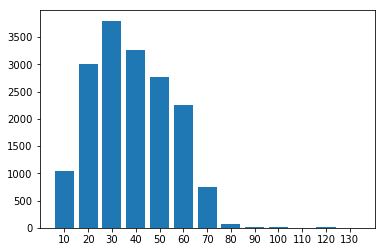

Test:


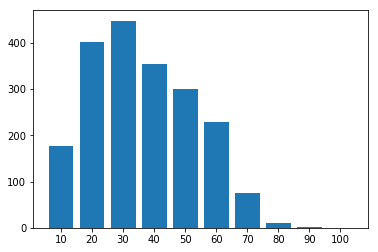

In [28]:
import matplotlib.pyplot as plt

def plot_histogram(hist):
    indxs = list(range(10,(len(hist)+1)*10, 10))
    plt.bar(range(len(hist)), [hist.get(i,0) for i in indxs], align='center')
    plt.xticks(range(len(hist)), indxs)
    plt.show()

print("Train:")
plot_histogram(lenhist_train)
print("Test:")
plot_histogram(lenhist_val)

**Versiones vectorizadas de los conjuntos de entrenamiento, validación y evaluación.**

Considere la función **corpus_vectorize** para construir la representación matricial mencionada anterioremente.


In [9]:
max_words = 30

def corpus_vectorize(corpus, vecs, max_words):
    X, y = [], []
    for r in corpus:
        s = r[0][:max_words] + ['###PADDING###'] * (max_words-len(r[0]))  # agrega padding o corta la oración
        row = []
        for w in s:
            if len(vectores(w)) == vectores.dim:  # control para la dimensión
                row.append(vectores(w))
            else:
                row.append(vectores('###PADDING###'))
        X.append(row)
        y.append(r[1])
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='int32')
    return X, y


X_train, y_train = corpus_vectorize(train, vectores, max_words)
X_val, y_val = corpus_vectorize(val, vectores, max_words)
X_test, y_test = corpus_vectorize(test, vectores, max_words)

print("X_train.shape: ", X_train.shape) 
print("X_val.shape: ", X_val.shape) 
print("X_test.shape: ", X_test.shape)


X_train.shape:  (16999, 30, 300)
X_val.shape:  (2000, 30, 300)
X_test.shape:  (5000, 30, 300)


## Definición de Modelo y Entrenamiento

En esta parte vamos a definir y entrenar modelos utilizando Keras.

Para realizar las partes se debe utilizar la referencia de keras: 

https://keras.io/layers/recurrent/

** Utilice el siguiente bloque de código para definir un modelo **


In [10]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation

model = Sequential()
model.add(LSTM(512, input_shape=(30,300), dropout=.1))

# ##### COMPLETAR RESTO DE LA DEFINICION DEL MODELO #####
               
model.add(Dense(1, activation='sigmoid'))


Using TensorFlow backend.


** Compilar el modelo definido **

Utilice el siguiente bloque de código para compilar el modelo. Puede modificar el código impartido.

In [11]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

** Entrenar el modelo compilado **

Complete el siguiente bloque de código para entrenar el modelo.

In [12]:
model.fit(X_train, y_train)

# ### COMPLETAR ###

Epoch 1/1
16999/16999 [==============================] - 2902s 171ms/step - loss: 0.4511 - acc: 0.7903


** Evaluar el modelo entrenado en el conjunto de validación **

Evaluar el modelo usando X_val e y_val con el método *evaluate*.

In [13]:
model.evaluate(X_val,y_val)

2000/2000 [==============================] - 118s 59ms/step


[0.39725326681137085, 0.82699999999999996]

** Evaluación con Precision, recall y F **

Considere la siguiente función para calcular las medidas P, R y F.

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_acc_p_r_f(model, X,y):
    # from: https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
    yhat_classes = model.predict_classes(X, verbose=0)[:, 0]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y, yhat_classes)
    print('F1 score: %f' % f1)
    
    return accuracy, precision, recall, f1

** Utilice la función anterior para calcular P, R y F en el conjunto de validación. **

In [15]:
get_acc_p_r_f(model, X_val, y_val)

Accuracy: 0.827000
Precision: 0.817805
Recall: 0.604900
F1 score: 0.695423


(0.82699999999999996,
 0.81780538302277428,
 0.60490045941807047,
 0.69542253521126762)

### Búsqueda de hiperparámetros

Una vez vista la secuencia completa para definir, compilar, entrenar y evaluar un modelo; vamos a determinar una buena configuración de hiperparámetros.

Debemos entener en cuenta hiperparámetros en cuanto a:

- Estructura del modelo: cantidad y tipo de capas, cantidad de nueronas
- Entrenamiento: método de entrenamiento, parámetros del métodos (learning rate, etc.)
- Regularizaciones: Dropout, Early Stopping
- Otras: Capas Bidireccionales, Capas Convolutivas, Combinaciones


Es elección de cada estudiante elegir una de las siguiente técnicas de entrenamiento:

- Manual Search
- Grid Search
- Random Search

** Utilice los bloques de código que considere necesarios para realizar la búsqueda de hiperparámetros y entrenamiento de su modelo**

In [17]:
# Búsqueda de hiperparámetros y entrenamiento
param_grid = dict(epochs=[1,5,10], dropout=[0, .1, .2], batch_size=[1,32,64])


model = Sequential()
model.add(LSTM(512, input_shape=(30,300)))

# ##### COMPLETAR RESTO DE LA DEFINICION DEL MODELO #####
               
model.add(Dense(1, activation='sigmoid'))
          
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

# Evaluación

Una vez encontrada una configuración adecuada de hiperparámetros haciendo uso del conjunto de validación, evaluamos el desempeño del modelo en los datos de evaluación.

** Muestre el desempeño del modelo final en los datos de test en cuanto a Acc, P, R y F. **


In [ ]:
# Evaluación del modelo entrenado
get_acc_p_r_f(model, X_test, y_test)

### Probar con entradas definidas por el usuario

Utilice lo visto anteriormente para ejecutar una entrada provista por el usuario con el modelo entrenado.

In [ ]:
def es_humor(model, entrada):
    # ### COMPLETAR ###
    return model.predict(entrada)